### Fetch data using python lidar

In [1]:
import pdal
import pandas as pd
import json
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point, mapping
import numpy as np
from pyproj import Proj, transform
import folium
import laspy as lp
import richdem as rd
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# Loading and reading the json file
def read_json(json_path):
    try:
        with open(json_path) as js:
            json_obj = json.load(js)
        return json_obj

    except FileNotFoundError:
        print('File not found.')

In [3]:
# Creating a function to change to the needed CRS format for better visualization

def convert_EPSG(fromT, lon, lat):
    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')
    if(fromT == 4326):
        input1 = P4326
        input2 = P3857
    else:
        input1=p3857
        input2=p4326
        
    x, y = transform(input1,input2, lon, lat)
    return [x, y]

In [4]:
# A function to change format of a list
    
def loop_EPSG_converter(listin):
    converted = []
    for item in listin:
        converted.append(convert_EPSG(4326, item[0], item[1]))
        
    return converted

In [5]:
# Generating a polygon given a co-ordinate and CRS format

def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [6]:
# Generating a data frame given a CRS format and pipe

def generate_geo_df(pipe, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        print(e)

In [7]:
# Co-ordinates for the polygon and generating the polygon from the given co-ordinate

coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]


polygon = generate_polygon(coordinates, 4326)

In [8]:
# A function to display the polygon on a map

def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    map = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(map)
    folium.LatLngPopup().add_to(map)
    return map

show_on_map(polygon, 20)

In [9]:
# Changing the co-ordinates of the polygon to the standard EPSG CRS format and generating a polgon

coor = loop_EPSG_converter(coordinates)
print(coor)
polygon_standard = generate_polygon(coor, 4326)

[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]


In [10]:
# Modifying the already created json file to fetch the data

def modify_pipe_json(json_loc, url, region, in_epsg, out_epsg):
    dicti = read_json(json_loc)
    dicti['pipeline'][0]['polygon'] = str(polygon_standard.iloc[:,0][0])
    dicti['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    dicti['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    dicti['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    print(dicti)
    return dicti
    
location = "../get_data.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326

request = modify_pipe_json(location, url, region, in_srs, out_srs)

{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification![7:7]', 'tag': 'no_noise'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}


In [11]:
# Creating the pipe
pipe = pdal.Pipeline(json.dumps(request))

In [12]:
# Finding out the number of points
pipe.execute()

1371

In [13]:
# Generating the dataframe from the pipeline

df = generate_geo_df(pipe, 4326)

In [14]:
# Displaying the dataframe

df.head()

,elevation,geometry
0,310.31,POINT (-93.75582 41.91801)
1,310.39,POINT (-93.75581 41.91801)
2,310.53,POINT (-93.75582 41.91801)
3,310.27,POINT (-93.75585 41.91803)
4,310.40,POINT (-93.75584 41.91803)


Text(89.375, 0.5, 'Latitude')

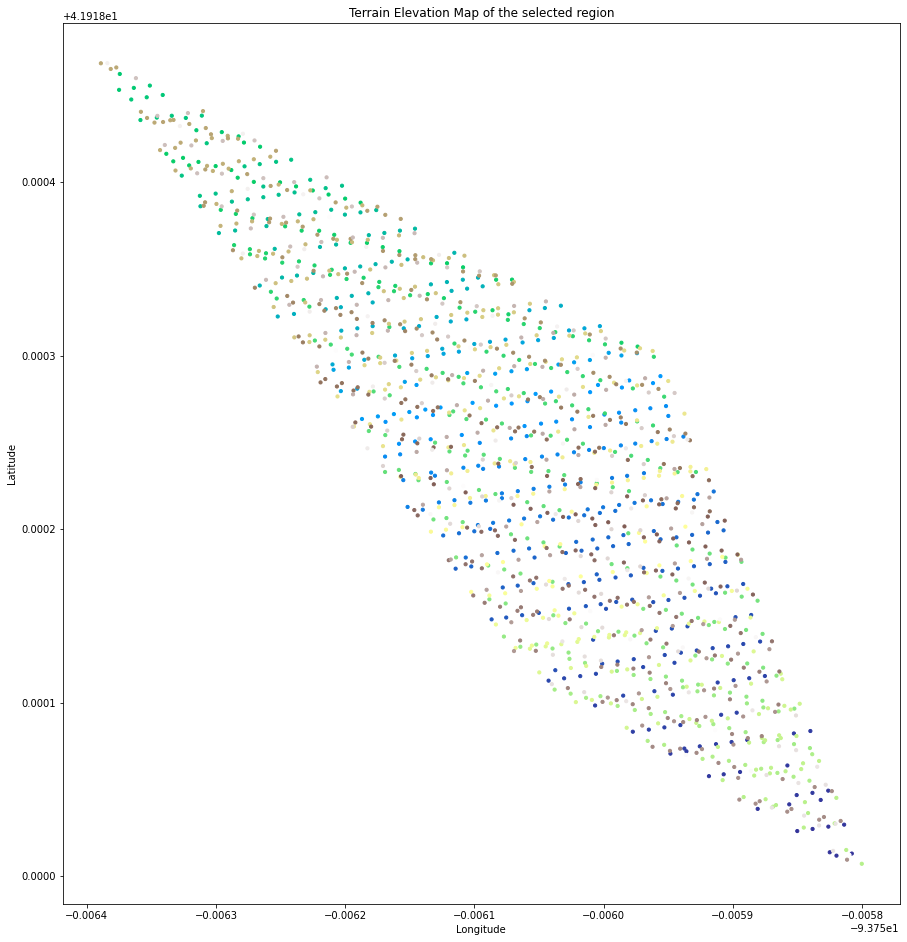

In [15]:
# Plotting the elevation graph

df.plot(c='elevation', scheme="quantiles", cmap='terrain', legend=True,
                                  markersize=10,
                                  figsize=(15, 20)
                                  )

plt.title('Terrain Elevation Map of the selected region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [16]:
# Reading the point cloud data from the las file using the laspy library

point_cloud = lp.read("iowa.las")
point_cloud

<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 1371 points, 3 vlrs)>

In [17]:
# Creating an array of co-ordinates and their elevation using the numpy vertical stack property

points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
points

array([[-93.76,  41.92, 310.31],
       [-93.76,  41.92, 310.39],
       [-93.76,  41.92, 310.53],
       ...,
       [-93.76,  41.92, 310.61],
       [-93.76,  41.92, 310.53],
       [-93.76,  41.92, 310.26]])

In [18]:
# Creating voxels for standardizing

voxel_size=1000
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
nb_vox

array([0., 0., 1.])

In [19]:
# Voxel griding

voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0
for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= points[idx_pts_vox_sorted[
    last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(
    voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] -
    np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]
    
voxel_grid

{(0,
  0,
  0): array([[-93.76,  41.92, 310.31],
        [-93.76,  41.92, 310.19],
        [-93.76,  41.92, 310.2 ],
        ...,
        [-93.76,  41.92, 310.33],
        [-93.76,  41.92, 310.2 ],
        [-93.76,  41.92, 310.26]])}

In [20]:
# Plots a 2D heat map for the point cloud data using matplotlib

def plot_heatmap(df, title) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    df.plot(column='elevation', ax=ax, legend=True, cmap="terrain")
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('../charts/heatmap.png')
    plt.show()

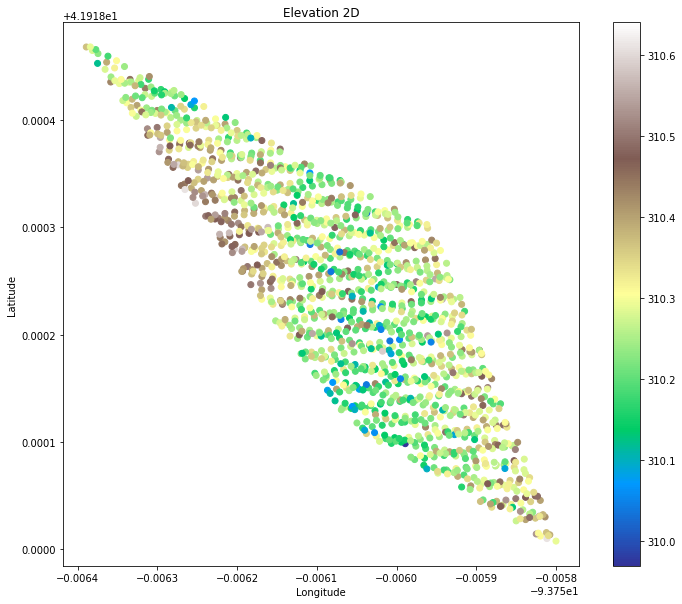

In [21]:
plot_heatmap(df,'Elevation 2D')

In [22]:
# Plots a 3D terrain scatter plot for the cloud data points of geopandas data frame using matplotlib

def render_3d(points, s: float = 0.01) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=s)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig('../charts/3Dview.png')
    plt.show()

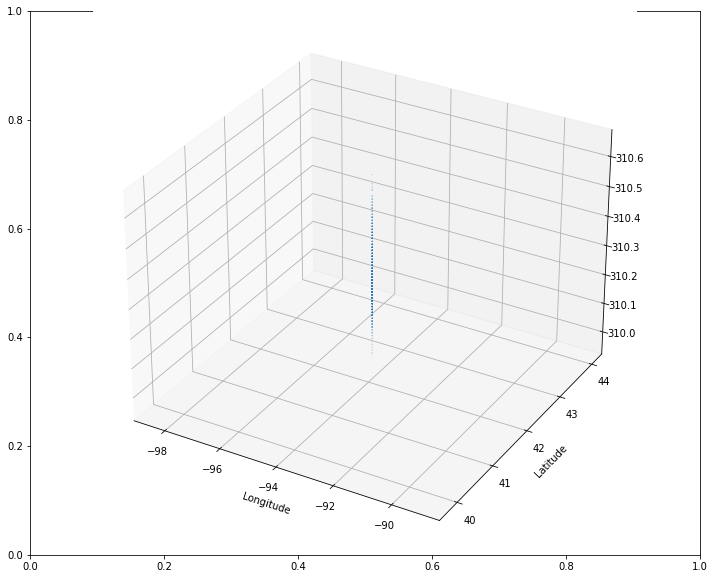

In [23]:
render_3d(points)